# ReTrain DKPN

Retrain  DKPN as in the paper. Following the up-to-date _SeisBench_ notebook

--------------------------------------------------------------------

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import obspy
import seisbench as sb

import dkpn.core as dkcore
import dkpn.train as dktrain

print(" SB version:  %s" % sb.__version__)
print("OBS version:  %s" % obspy.__version__)

 SB version:  0.4.0
OBS version:  1.4.0


In [2]:
# ---------------------------------------------
DATASET_TRAIN = "ETHZ"
DATASET_TEST = "ETHZ"
DATASET_SIZE = "Nano"
RANDOM_SEED = 42

EPOCHS = 25
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

# ---------------------------------------------
MODEL_NAME = "DKPN_TrainDataSet_%s_Size_%s_Rnd_%d_Epochs_%d_LR_%06.4f_Batch_%d" % (
                          DATASET_TRAIN, DATASET_SIZE, RANDOM_SEED, EPOCHS, LEARNING_RATE, BATCH_SIZE)

STORE_DIR_MODEL = Path(MODEL_NAME)
if not STORE_DIR_MODEL.is_dir():
    STORE_DIR_MODEL.mkdir()

### SELECT DATASET and SIZE

Here you can decide to load the same dataset for _In-Domain_ tests, or a different one for _Cross-Domain_ testing.

In [3]:
(dataset_train, dataset_test) = dktrain.select_database_and_size(
                                    DATASET_TRAIN, DATASET_TEST, DATASET_SIZE, RANDOM_SEED=RANDOM_SEED)
train = dataset_train.train()
dev = dataset_train.dev()
test = dataset_test.test()

print("TRAIN samples %s:  %d" % (DATASET_TRAIN, len(train)))
print("  DEV samples %s:  %d" % (DATASET_TRAIN, len(dev)))
print(" TEST samples %s:  %d" % (DATASET_TEST, len(test)))

2023-06-09 13:44:54,428 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb


Selecting DATASET TRAIN/DEV: ETHZ
Selecting DATASET TEST:      ETHZ
Selecting DATASET SIZE:      NANO


2023-06-09 13:44:54,774 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb


TRAIN samples ETHZ:  734
  DEV samples ETHZ:  73
 TEST samples ETHZ:  35936


-----------------------------------

# INITIALIZE DKPN

In this slot we initialize the picker and prepare 

In [4]:
mydkpn = dkcore.DKPN()  # Instantiate
mydkpn.cuda();
mydkpn.get_defaults()   # This are the parameter that will be used!

{'overlap': 1500,
 'P_threshold': 0.2,
 'S_threshold': 0.2,
 'fp_stabilization': 4,
 't_long': 4,
 'freqmin': 0.5,
 'corner': 1,
 'perc_taper': 0.1,
 'mode': 'rms',
 'clip': -999,
 'log': True,
 'normalize': False,
 'polarization_win_len': 1,
 'use_amax_only': False}

Epoch 1
-------------------------------
> /scratch/bagagli/AQ2009/FinalAnalysis/TMP-DKPN/dkpn/train.py(260)__train_loop__()
    258             # Compute prediction and loss
    259             import pdb; pdb.set_trace()  #MB
--> 260             pred = self.dkpnmod(batch["X"].to(
    261                                         self.dkpnmod.device))
    262             loss = self.__loss_fn__(pred, batch["y"].to(



ipdb>  import matplotlib.pyplot as plt; plt.plot(batch["X"][0].T); plt.show()


[<matplotlib.lines.Line2D object at 0x7fd64b819040>, <matplotlib.lines.Line2D object at 0x7fd64b8190a0>, <matplotlib.lines.Line2D object at 0x7fd64b874ee0>, <matplotlib.lines.Line2D object at 0x7fd64b874f10>, <matplotlib.lines.Line2D object at 0x7fd64b869370>]


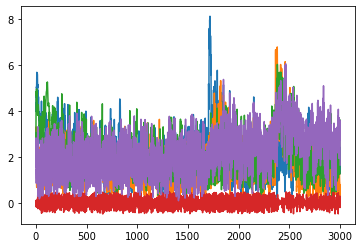

ipdb>  import matplotlib.pyplot as plt; plt.plot(batch["Xorig"][0].T); plt.show()


[<matplotlib.lines.Line2D object at 0x7fd6283af5e0>, <matplotlib.lines.Line2D object at 0x7fd6283af640>, <matplotlib.lines.Line2D object at 0x7fd6283af760>]


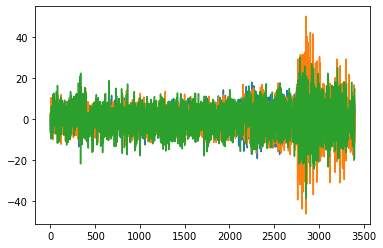

ipdb>  c


loss: 1.291837  [    0/  734]
> /scratch/bagagli/AQ2009/FinalAnalysis/TMP-DKPN/dkpn/train.py(259)__train_loop__()
    257         for batch_id, batch in enumerate(self.train_loader):
    258             # Compute prediction and loss
--> 259             import pdb; pdb.set_trace()  #MB
    260             pred = self.dkpnmod(batch["X"].to(
    261                                         self.dkpnmod.device))



ipdb>  import matplotlib.pyplot as plt; plt.plot(batch["Xorig"][0].T); plt.show()


[<matplotlib.lines.Line2D object at 0x7fd625be16a0>, <matplotlib.lines.Line2D object at 0x7fd625be1700>, <matplotlib.lines.Line2D object at 0x7fd625be1820>]


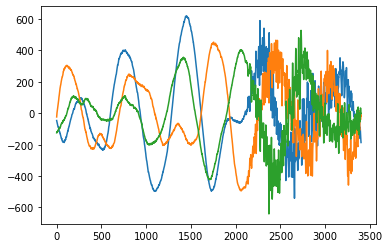

ipdb>  c


> /scratch/bagagli/AQ2009/FinalAnalysis/TMP-DKPN/dkpn/train.py(260)__train_loop__()
    258             # Compute prediction and loss
    259             import pdb; pdb.set_trace()  #MB
--> 260             pred = self.dkpnmod(batch["X"].to(
    261                                         self.dkpnmod.device))
    262             loss = self.__loss_fn__(pred, batch["y"].to(



ipdb>  import matplotlib.pyplot as plt; plt.plot(batch["Xorig"][0].T); plt.show()


[<matplotlib.lines.Line2D object at 0x7fd6233f7040>, <matplotlib.lines.Line2D object at 0x7fd6233f70a0>, <matplotlib.lines.Line2D object at 0x7fd6233f71c0>]


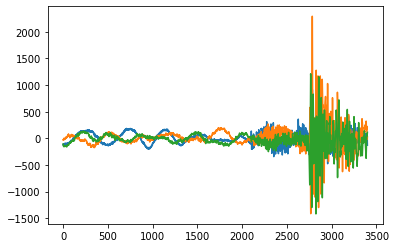

ipdb>  q


BdbQuit: 

In [5]:
TRAIN_CLASS = dktrain.TrainHelp_DomainKnowledgePhaseNet(
                mydkpn,  # It will contains the default args for StreamCF calculations!!!
                train,
                dev,
                test,
                augmentations_par = {
                    "amp_norm_type": "std",
                    "window_strategy": "move",  # "pad"
                    "final_windowlength": 3001,
                    "sigma": 10,
                    "phase_dict": {
                        "trace_p_arrival_sample": "P",
                        "trace_pP_arrival_sample": "P",
                        "trace_P_arrival_sample": "P",
                        "trace_P1_arrival_sample": "P",
                        "trace_Pg_arrival_sample": "P",
                        "trace_Pn_arrival_sample": "P",
                        "trace_PmP_arrival_sample": "P",
                        "trace_pwP_arrival_sample": "P",
                        "trace_pwPm_arrival_sample": "P",
                        "trace_s_arrival_sample": "S",
                        "trace_S_arrival_sample": "S",
                        "trace_S1_arrival_sample": "S",
                        "trace_Sg_arrival_sample": "S",
                        "trace_SmS_arrival_sample": "S",
                        "trace_Sn_arrival_sample": "S"
                    },
                },
                batch_size=BATCH_SIZE,
                num_workers=24,
                random_seed=RANDOM_SEED)

# --------------->    ACTUAL TRAINING  <---------------

train_loss_epochs, dev_loss_epochs = TRAIN_CLASS.train_me(epochs=EPOCHS, optimizer_type="adam", learning_rate=LEARNING_RATE)
TRAIN_CLASS.store_weigths(STORE_DIR_MODEL, MODEL_NAME, MODEL_NAME, version="1")

# Store TABLE
with open(str(STORE_DIR_MODEL / "TRAIN_TEST_loss.csv"), "w") as OUT:
    OUT.write("EPOCH, TRAIN_LOSS, TEST_LOSS"+os.linesep)
    for xx, (trn, tst) in enumerate(zip(train_loss_epochs, dev_loss_epochs)):
        OUT.write(("%d, %.4f, %.4f"+os.linesep) % (xx, trn, tst))

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss_epochs, label="TRAIN_Loss", color="red", lw=2)
plt.plot(dev_loss_epochs, label="DEV_Loss", color="teal", lw=2)
plt.xlabel("epochs")
plt.ylabel("cross-entropy loss")
# plt.ylim([0,0.1])
# plt.yscale("log")
plt.legend()
fig.savefig(str(STORE_DIR_MODEL / "TrainTest_LOSS.pdf"))
plt.show()